In [1]:
""" 와인 데이터 정리 """
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_wine = pd.read_csv('../Dataset/wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol',
                  'Malic acid', 'Ash',
                  'Alcalinity of ash', 'Magnesium',
                  'Total phenols', 'Flavanoids',
                  'Nonflavanoid phenols',
                  'Proanthocyanins',
                  'Color intensity', 'Hue',
                  'OD280/OD315 of diluted wines',
                  'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [2]:
""" 순차적 후진 선택 알고리즘 구현 """
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS() :
    def __init__(self, estimator, k_features, scoring = accuracy_score,
                test_size = 0.25, random_state = 1) :
        # accuracy_score 함수는 특성의 부분 집합에 대한 모델 (분류를 위한 추정기) 성능을 평가한다.
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y) :
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = self.test_size,
                                                           random_state = self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features : 
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r = dim - 1) :
                # itertools.combination 함수에 의해 특성 조합을 생성하고, for문을 통해 평가 및 축소한다.
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X) : 
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices) :
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        
        return score

In [3]:
""" KNN을 통한 동작 확인 """
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
sbs = SBS(knn, k_features = 1)
sbs.fit(X_train_std, y_train)

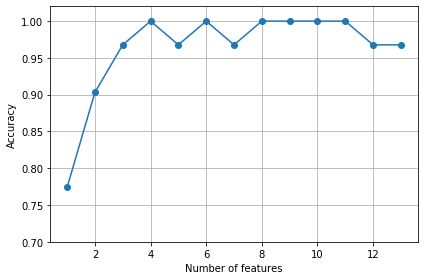

In [4]:
""" 검증 세트에서 계산한 KNN 분류기의 정확도 """

k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [5]:
""" 특성 확인 """

k4 = list(sbs.subsets_[9])
print(df_wine.columns[1:][k4])

Index(['Alcohol', 'Magnesium', 'Total phenols', 'Color intensity'], dtype='object')


In [6]:
""" 성능 비교 """

# 기존 특성의 데이터 셋
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))
print('테스트 정확도:', knn.score(X_test_std, y_test))

# 축소 후 데이터 셋
knn.fit(X_train_std[:, k4], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k4], y_train))
print('테스트 정확도:', knn.score(X_test_std[:, k4], y_test))

훈련 정확도: 0.9596774193548387
테스트 정확도: 0.9259259259259259
훈련 정확도: 0.9435483870967742
테스트 정확도: 0.8888888888888888
